<a href="https://colab.research.google.com/github/ketanhdoshi/ml/blob/master/lib/util_lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utility Functions

### Imports

In [ ]:
#export

from fastai import datasets
import pickle, gzip
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import *
from concurrent.futures import ProcessPoolExecutor
import torch
from torch import tensor
import torch.nn.functional as F

### MNIST Data

In [ ]:
#export

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

#----------------------------------------------------
# Download Mnist dataset, unpickle it and convert from numpy arrays to tensors
#----------------------------------------------------
def get_mnist_data():
  # Download the data
  path = datasets.download_data(MNIST_URL, ext='.gz')
    
  # Unpickle the dataset
  with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
  # Convert from numpy arrays to tensors
  return map(tensor, (x_train,y_train,x_valid,y_valid))

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([50000, 784]) torch.Size([50000]) <class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([10000, 784]) torch.Size([10000])


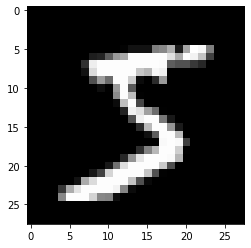

In [ ]:
x_train,y_train,x_valid,y_valid = get_mnist_data()
print (type(x_train), type(y_train), x_train.shape, y_train.shape, type(x_valid), type(y_valid), x_valid.shape, y_valid.shape)

# Get the first image from the training set, reshape it to (28,28) and display it
mpl.rcParams['image.cmap'] = 'gray'
img = x_train[0]
plt.imshow(img.view((28,28)))

### Pickle save and load

In [ ]:
#export

def save_pickle(obj, pickle_dir, pickle_file):
  pickle_dir.mkdir(exist_ok=True)
  with open(pickle_dir/pickle_file, 'wb') as file_pi:
    pickle.dump(obj, file_pi)

def load_pickle(pickle_path):
  with open(pickle_path, 'rb') as file_pi:
    obj = pickle.load(file_pi)
  return obj

### Tensor comparisons

In [ ]:
#export

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"
    
#----------------------------------------------------
# Check if two tensors are almost equal, within some tolerance
#----------------------------------------------------
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

#----------------------------------------------------
# Check if a value is close to zero, within some tolerance
#----------------------------------------------------
def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

### Metrics Functions

In [ ]:
#export

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

def dice(pred, targs):
  pred = (pred>0).float()
  return 2. * (pred*targs).sum() / (pred+targs).sum()

def accuracy_thresh(y_pred, y_true, thresh:float=0.5, sigmoid:bool=True):
  if sigmoid: y_pred = y_pred.sigmoid()
  return ((y_pred>thresh).byte()==y_true.byte()).float().mean()

#----------------------------------------------------
# Mean Square Error
#----------------------------------------------------
def mse(pred, targs):
  error = F.mse_loss (pred, targs)
  return error

#----------------------------------------------------
# Root Mean Square Error
#----------------------------------------------------
def rmse(pred, targs):
  error = torch.sqrt(F.mse_loss (pred, targs))
  return error

#----------------------------------------------------
# Root Mean Square Percentage Error
#----------------------------------------------------
def rmspe(pred, targs):
  #error = rmse(torch.log(pred), torch.log(targs))

  pred, targs = torch.exp(pred), torch.exp(targs)
  pct_var = (targs - pred)/targs
  perror = torch.sqrt((pct_var**2).mean())

  #test_near_zero (perror - error)
  return perror

### Number operations

In [ ]:
#export

#----------------------------------------------------
# Normalise data by subtracting the mean, and dividing by the standard deviation
#----------------------------------------------------
def normalize(x, m, s): return (x-m)/s

#----------------------------------------------------
# Convenience function to normalise the training and validation data using
# the mean and std of the training data (never the validation data)
#----------------------------------------------------
def normalize_tr_val(x_train, x_valid):
    m,s = x_train.mean(),x_train.std()
    return normalize(x_train, m, s), normalize(x_valid, m, s)

In [ ]:
x_train,y_train,x_valid,y_valid = get_mnist_data()

# Normalise the training data
# After normalisation the training data will have mean=0, and std=1
x_train = normalize(x_train, x_train.mean(), x_train.std())
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

### Define a Utility ListContainer class to hold lists of objects

In [ ]:
#export

#----------------------------------------------------
# Convenience function to make a list
#----------------------------------------------------
def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

#----------------------------------------------------
# Utility class to hold lists of objects which allows indexing and slicing using:
#     a single index
#     a slice (like 1:5)
#     a list of indices
#     a mask of indices ([True,False,False,True,...])
#  The __iter__ method is there to be able to do things like for x in ....
#----------------------------------------------------
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
      
t = ListContainer(range(10))
t, t[[1,2]], t[[False]*8 + [True,False]]

(ListContainer (10 items)
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 2], [8])

### Reproducible Random Numbers

In [ ]:
#export

#----------------------------------------------------
# Used during troubleshooting to set the Random Number Generator to a known
# state. Setting the random seed explicitly ensures that all model weights are 
# initialised to the same value each time
#
# To use it:
#     Call DebugRand.set_seed() before operation
#     Perform operation that requires random numbers 
#     Optionally, call DebugRand.show_state() after operation
#----------------------------------------------------
class DebugRand():
  _pre=None

  # By default, this function does nothing. Set this to true to enable the
  # functionality
  repro=False

  @classmethod
  def set_seed(cls, seed):
    if (not cls.repro): return

    # Save away the 'pre' RNG state before setting the seed, so that we can print 
    # it out later
    cls._pre = cls._get_pre()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

  @classmethod
  def show_state(cls, *args):
    if (not cls.repro): return

    # Get the current RNG state 'post' the operation
    cur = cls._get_pre()
    print ('RNG State', cls._pre, cur, *args)
    # Save the current state
    cls._pre = cur

  @staticmethod
  def _get_pre(): 
    return torch.get_rng_state().float().mean()

### Compose Function

In [ ]:
#export

def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

### Parallel Function

In [ ]:
#export

def parallel(func, arr, max_workers=4):
    if max_workers<2: results = list(map(func, enumerate(arr)))
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            return list(ex.map(func, enumerate(arr)))
    if any([o is not None for o in results]): return results

### Export

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gn_path = 'gdrive/My Drive/Colab Notebooks'  #change dir to your project folder

In [ ]:
!wget https://raw.githubusercontent.com/ketanhdoshi/ml/master/lib/nb_export.py

In [ ]:
from nb_export import notebook2scriptSingle
notebook2scriptSingle(gn_path + '/lib/util_lib.ipynb', gn_path + '/exp')

Converted gdrive/My Drive/Colab Notebooks/lib/util_lib.ipynb to gdrive/My Drive/Colab Notebooks/exp/nb_util.py
